# Emotion recognition group 16
### Members
- Rens Scheepers: 1622749
- Zijian Dong: 2268264
- Timo Vojnic Zelic: 172411

Python version: 3.13.5  

packages used:
- numpy

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pickle

from dataclasses import dataclass

# data preperation
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import AffineTransform, warp, rotate

# feature extraction
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor as sk_gabor
from skimage.measure import moments_hu
from scipy.fft import dctn
from scipy.signal import convolve2d

# feature selection
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# build representation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA ,FastICA 

# data representation
from sklearn.preprocessing import StandardScaler

# machine learning models
from sklearn.svm import SVC


EMOTION_CLASSES = {
    0:'0: Angry',
    1:'1: Disgust',
    2:'2: Fear',
    3:'3: Happy',
    4:'4: Sad',
    5:'5: Surprise',
    6:'6: Neutral'
}


In [3]:
# load the data into dataframes
train_data_raw = pd.read_csv("data/fer2013_train.csv") 
validation_data = pd.read_csv("data/fer2013_validation.csv") 
test_data = pd.read_csv("data/fer2013_test.csv") 

Starting distribution of data per class:
0: Angry: 3995
1: Disgust: 436
2: Fear: 4097
3: Happy: 7215
4: Sad: 4830
5: Surprise: 3171
6: Neutral: 4965


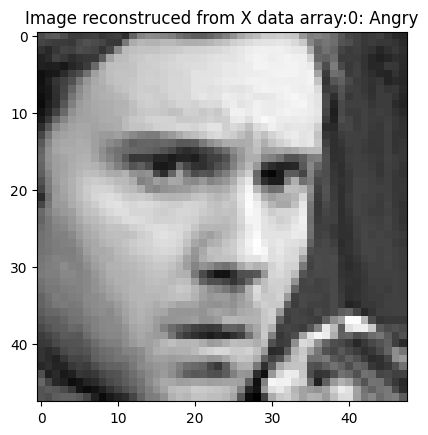

Class 0: +3221 augmented added
Class 1: +6780 augmented added
Class 2: +3119 augmented added
Class 3: +1 augmented added
Class 4: +2386 augmented added
Class 5: +4045 augmented added
Class 6: +2251 augmented added
Distribution of data per class after augmentation:
0: Angry: 7216
1: Disgust: 7216
2: Fear: 7216
3: Happy: 7216
4: Sad: 7216
5: Surprise: 7216
6: Neutral: 7216


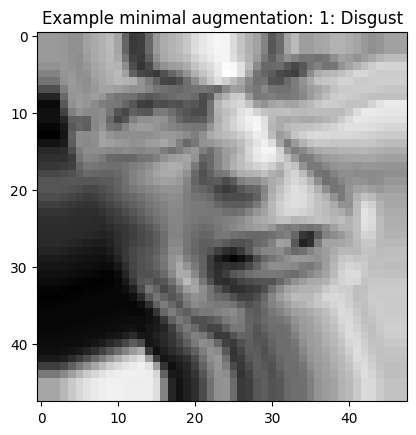

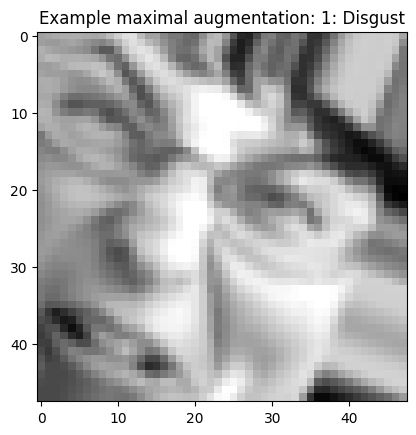

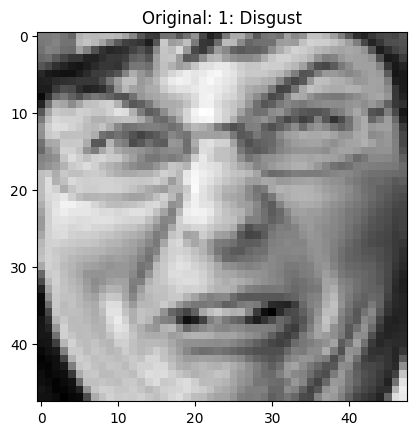

In [ ]:
class DataAugmentation:
    """
    Augment only the under-represented classes with label preserving transformations.
    Augmentation should reduce variance and improve invariance.
    Invariants:
    - translation 
    - rotation 
    - scaling 
    - lighting 
    - horizontal flip (because faces are horizontally symmetric, they are not vertically symmetric)

    Give class weights to use in training. they correct residual imbalance seen by the loss. 
    It should not have to be used, as augmentation already balances the dataset

    output:
    - self.X_data_augmented
    - self.Y_data_augmented 
    """
    def __init__(self, data: pd.DataFrame, verbose: bool = False):
        self.data = data
        self.verbose = verbose
        self.rng = np.random.default_rng(1712411)

        # the uniformly sampled probability that determines whether an operation is done when augmenting
        self.augment_probabilities = {
            "translation": 0.8,
            "rotate": 0.4,
            "scaling": 0.5,
            "lighting": 0.2,
            "horizontal-flip": 0.5
        }

        # The range in which a uniformly sample value determines the augmentation
        self.augment_range = {
            "translation": (-6,6), # pixels
            "rotate": (-20,20), # degrees
            "scaling": (0.9, 1.1), # factor
            "lighting": (0.75, 1.25) # factor
        }

        # self.x_y_split() # generate X_data (N, 48, 48), Y_data (N,) 
        # self.data_augmentation() # generate X_data_augmented (N, 48, 48), Y_data_augmented (N,)  

    # invariant augmentations (use scikit-image):
    def translation(self, X_data:np.ndarray, pixels: tuple[int, int]) -> np.ndarray:
        """ Translate by an amount of pixels (x,y) (stay between 2 and 6)."""
        tx, ty = pixels # amount of pixels to translate in x and y

        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            # translation is affine transform
            tform = AffineTransform(translation=(tx, ty))
            augmented = warp(image, tform.inverse, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return augmented_data
    
    def rotation(self, X_data:np.ndarray, degrees: float) -> np.ndarray:
        """ Give the image pixels a rotation around the center (stay between -20, 20 degrees)."""
        
        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            augmented = rotate(image, angle=degrees, resize=False, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return augmented_data

    def scaling(self, X_data:np.ndarray, factor: float) -> np.ndarray:
        """ Scale the image pixels (stay between 0.8 and 1.2 %)"""
        # center image
        height, width = X_data.shape[1], X_data.shape[2]
        cx, cy = width / 2.0, height / 2.0

        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            t1 = AffineTransform(translation=(-cx, -cy)) # translate to origin
            s  = AffineTransform(scale=(factor, factor)) # scale by factor
            t2 = AffineTransform(translation=(cx, cy)) # translate back 
            tform = t1 + s + t2
            augmented = warp(image, tform.inverse, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return  augmented_data
    
    def lighting(self, X_data:np.ndarray, light_intensity: float) -> np.ndarray:
        """ Change the lighting of all pixels (stay between 0.8 and 1.2)."""
        out = (X_data.astype(np.float32) * light_intensity) # change lighting intensity by multiplying with factor
        return np.clip(out, 0.0, 1.0).astype(np.float32) # stay within normalized range

    def horizontal_flip(self, X_data:np.ndarray) -> np.ndarray:
        """ flip over the y axis """
        return np.flip(X_data,axis=2)
    
    # building up X and Y for feature extraction:
    def x_y_split(self) -> tuple[np.ndarray, np.ndarray]:
        """Turn the dataframe into X and Y arrays
        optionally print the distribution per class to good a sense of class representation in the data. """
        # turn dataframe into numpy array with grayscale values
        X_data = np.array([np.fromstring(pixels, sep=' ') for pixels in self.data['pixels']]) 
        # normalize X_data [0,255] to [0,1]
        X_data = X_data.astype(np.float32)  / 255.0
        # get X data into 48x48 image pixel grid 
        X_data = X_data.reshape(-1, 48, 48)
        
        # get numeric class labels into numpy array
        Y_data = np.array(self.data['emotion'].values)
        if self.verbose:
            # count how many items are in the data set for each class 
            unique, counts = np.unique(Y_data, return_counts=True)
            print("Starting distribution of data per class:")
            for label, count in zip(unique, counts):
                print(f"{EMOTION_CLASSES[label]}: {count}")

            plt.imshow(X_data[0], cmap='gray')
            plt.title(f"Image reconstruced from X data array:{EMOTION_CLASSES[Y_data[0]]}")
            plt.show()
        
        return X_data, Y_data
    
    def data_augmentation(self):
        """ Combine the invariant operations to balance out under under represented classes.
        Randomly perform augmentations, the probabilities can be changed in class configuration."""
        X_data, Y_data = self.x_y_split()
        
        classes, counts = np.unique(Y_data, return_counts=True)
        target_image_n = counts.max() # aim for every class to have the same amount of images as the largest class has

        # make lists to append
        X_out = [X_data]
        Y_out = [Y_data]

        for c, n in zip(classes, counts): # iterate over classes and amount of images they have
            images_needed = target_image_n - n + 1 # make at least one augment image for the class with the most images
            
            class_indexes = np.where(Y_data==c)[0] # select the images of the current class
            augmented_images = []

            for _ in range(images_needed):
                index = int(self.rng.choice(class_indexes)) # pick a random image to augment
                img = X_data[index][None, ...]  # shape (1,48,48) to use the X_data input

                # apply augmentations based on probabilities
                if self.rng.random() < self.augment_probabilities["translation"]:
                    # apply translation if random number is below threshold probability
                    lo, hi = self.augment_range["translation"]   # (0.8, 1.2)
                    tx = int(self.rng.uniform(lo, hi))
                    ty = int(self.rng.uniform(lo, hi))
                    img = self.translation(img, (tx, ty)) 
                
                if self.rng.random() < self.augment_probabilities["rotate"]:
                    lo, hi = self.augment_range["rotate"]    
                    degree = float(self.rng.uniform(lo, hi))
                    img = self.rotation(img, degree) 

                if self.rng.random() < self.augment_probabilities["scaling"]:
                    lo, hi = self.augment_range["scaling"]   
                    factor = float(self.rng.uniform(lo, hi))
                    img = self.scaling(img, factor) 

                if self.rng.random() < self.augment_probabilities["lighting"]:
                    lo, hi = self.augment_range["lighting"]  
                    light_intensity = float(self.rng.uniform(lo, hi))
                    img = self.lighting(img, light_intensity) 

                if self.rng.random() < self.augment_probabilities["horizontal-flip"]:
                    img = self.horizontal_flip(img)
                
                augmented_images.append(img[0]) # add to list

            # save images in X,Y format
            aug_imgs = np.stack(augmented_images, axis=0).astype(np.float32)
            aug_labels = np.full(images_needed, c, dtype=Y_data.dtype)

            X_out.append(aug_imgs)
            Y_out.append(aug_labels)
            
            # print how many images where added with augmentation
            if self.verbose:
                print(f"Class {c}: +{images_needed} augmented added")
        
        X_data_augmented = np.concatenate(X_out, axis=0).astype(np.float32)
        Y_data_augmented = np.concatenate(Y_out, axis=0)

        # summary of resulting distributions per class
        if self.verbose:
            unique, counts = np.unique(Y_data_augmented, return_counts=True)
            print("Distribution of data per class after augmentation:")
            for label, count in zip(unique, counts):
                print(f"{EMOTION_CLASSES[label]}: {count}")
        
        # show what augmentation is doing
        if self.verbose:
            class_select = 1 # 1 = disgust
            class_indexes = np.where(Y_data==class_select)[0]
            img = X_data[class_indexes[0]][None, ...] # get the first image for disgust

            min_params = {
                "translate": (self.augment_range["translation"][0], self.augment_range["translation"][0]),
                "rotate": self.augment_range["rotate"][0],
                "scaling": self.augment_range["scaling"][0],
                "lighting": self.augment_range["lighting"][0]
            }

            max_params = {
                "translate": (self.augment_range["translation"][1], self.augment_range["translation"][1]),
                "rotate": self.augment_range["rotate"][1],
                "scaling": self.augment_range["scaling"][1],
                "lighting": self.augment_range["lighting"][1]
            }

            # apply all augmentations
            for label, params in [("minimal", min_params), ("maximal", max_params)]:
                img_aug = self.translation(img, params["translate"])
                img_aug = self.rotation(img_aug, params["rotate"])
                img_aug = self.scaling(img_aug, params["scaling"])
                img_aug = self.lighting(img_aug, params["lighting"])
                img_aug = self.horizontal_flip(img_aug)

                plt.imshow(img_aug[0], cmap="gray")  # show 2D
                plt.title(f"Example {label} augmentation: {EMOTION_CLASSES[class_select]}")
                plt.show()

            # Show original for reference
            plt.imshow(img[0], cmap="gray")
            plt.title(f"Original: {EMOTION_CLASSES[class_select]}")
            plt.show()
        
        return X_data_augmented, Y_data_augmented
    
    def class_weights(self, Y_data_augmented: np.ndarray):
        """ Use sklearns tool to get class weights based on the augmented Y data labels """
        classes = np.unique(Y_data_augmented)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_data_augmented)
        class_weight_dict = {c:w for c, w in zip(classes, class_weights)}
        print("Class weights for training")
        if self.verbose:
            for c, w in class_weight_dict:
                print(f"{EMOTION_CLASSES[c]}: {w}")
        return class_weight_dict
    
X_train_augmented, Y_train_augmented = DataAugmentation(train_data_raw, verbose=True).data_augmentation()
X_validation, Y_validation = DataAugmentation(validation_data, verbose=False).x_y_split()
X_test, Y_test = DataAugmentation(validation_data, verbose=False).x_y_split()

### Feature Extraction
The data comes in as 48x48 values between 0 and 1; it is 2304 dimensional and has high entropy.
Intuitivly what indicates an emotion in the original representation is:
- mouth position
- eye size
- eyebrow position
These things are indicated with regions of contrasting greyscale 

The features that are used are:
- HOG (historgram of oriented gradients)
    - Encodes local edge direction and contrast: gives edges and contours of facial features.
    - Uses small cells (like 8x8 pixels), kind of like a convolutional network.
- LBP (local binary pattern)
    - Compares the brightness of a pixel to its neighbours; this patterns forms a small binary number describing local texture.
    - It recognizes micro-textures like fabric, hair and skin.
- GLCM (gray level co-occurence matrix)
    - Captures how often gray levels occur next to each other at a specific distance and direction.
    - The resulting matrix allows for getting Haralick features like contrast, energy, homogenity and correlation
- DCT (discrete cosine transform)
    - Works with a frequency domain representation, low frequencies are smooth regions, high frequencies are fine detail.
    - kepping low frequency parts (low coefficients) gives a representation with reduced noise
    - gives global frequency components
    - how smooth is the image overall?
- wavelet transform
    - Wavelet decomposition gives scales like levels of zooming, at each level a sub images give details.
    - A summary of a sub image (mean, variance, energy), captures multi-scale texture and local frequency information.
    - gives both spatial and frequnecy localization
    - what details exist at what scales?
- gabor filter
    - oriented wavelets, edge detetctors tuned to specific direction and scales
    - Use multiple gabor filters and get the averge energy of each response.
    - They seem to mimic the visual cortex
    - gives a texture map; directional and localized texture analysis
    - what are oriented textures or edges
- hu moments
    - seven values computed from the geometric moments of an image, describing overall shape structure.
    - invariant to rotation, scale and translation; see if an image is round, elongated or symmetric.
- zernike moments
    - similar to hu moments bu computed using orthogonal polynomials

Finally run PCA and ICA

In [ ]:
class Features:
    def __init__(self, X_data:np.ndarray):
        self.X = X_data # (48, 48, N)

        self._feature_names, self._features  = Features.available()
    
    def feature(fn):
        """ make a decorator for available functions"""
        fn._is_feature = True
        return fn
    
    @classmethod
    def available(cls):
        """ expose available methods to outside world"""
        fns = [
            getattr(cls, name)
            for name in dir(cls)
            if getattr(getattr(cls, name), "_is_feature", False)
        ] # this stores the executable methods that have the feature decorator
        names = tuple(fn.__name__ for fn in fns) # this only stores the names as strings
        return names, fns

    @feature
    def HOG(self, cell_pixels: int = 8, block: int = 2, nbins: int = 9) -> np.ndarray:
        """ Histogram of Oriented Gradients
        inputs:
        - cell_pixels: cell size in pixels (default 8 -> 8x8)
        - block: block size in cells (default 2 -> 2x2 cells)
        - nbins: #bins for unsigned orientation (0..180°), default 9
        output:
        - array (N, feat_len); for 48x48 with 8px cells and 2x2 blocks -> (N, 900)
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):  # loop over images, hog itself is optimized
            img = self.X[:, :, i].astype(np.float32)
            f = hog(
                img,
                pixels_per_cell=(cell_pixels, cell_pixels),
                cells_per_block=(block, block),
                orientations=nbins,
                visualize=False,
                feature_vector=True
            )
            feats.append(f.astype(np.float32))
        return np.stack(feats, axis=0)

    @feature
    def LBP(self, P: int = 8, R: float = 1.0, method: str = "uniform", n_bins: int | None = None) -> np.ndarray:
        """ Local Binary Pattern (histogram)
        inputs:
        - P: #circular neighbors
        - R: radius
        - method: 'uniform'|'default'|'ror' etc. (skimage)
        - n_bins: histogram bins; if None and method='uniform' -> P+2
        output:
        - array (N, n_bins); for P=8 with 'uniform' -> (N, 10)
        """
        H, W, N = self.X.shape
        if n_bins is None and method == "uniform":
            n_bins = P + 2  # skimage convention for uniform
        feats = []
        for i in range(N):
            img = self.X[:, :, i].astype(np.float32)
            lbp = local_binary_pattern(img, P=P, R=R, method=method)
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            feats.append(hist.astype(np.float32))
        return np.stack(feats, axis=0)

    def glcm_np(self, image: np.ndarray, levels: int = 32, distances=(1,), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                symmetric: bool = True, normed: bool = True) -> np.ndarray:
        """ build co-occurrence tensor P without skimage.greycomatrix
        inputs:
        - image: 2D grayscale; internally normalized + quantized to [0, levels-1]
        - levels: quantization levels
        - distances: offsets (pixels)
        - angles: directions (radians)
        output:
        - P with shape (levels, levels, len(distances), len(angles))
        """
        img = image.astype(np.float32)
        imn = img - img.min()
        imn = imn / (imn.max() + 1e-6)
        q = np.floor(imn * (levels - 1)).astype(np.int32)

        H, W = q.shape
        P = np.zeros((levels, levels, len(distances), len(angles)), dtype=np.float64)

        offsets = []
        for d in distances:
            for a in angles:
                dy = int(round(np.sin(a) * d))
                dx = int(round(np.cos(a) * d))
                offsets.append((dy, dx))

        k = 0
        for di, _d in enumerate(distances):
            for ai, _a in enumerate(angles):
                dy, dx = offsets[k]; k += 1

                if dy >= 0:
                    ys = slice(0, H - dy); yt = slice(dy, H)
                else:
                    ys = slice(-dy, H);     yt = slice(0, H + dy)
                if dx >= 0:
                    xs = slice(0, W - dx); xt = slice(dx, W)
                else:
                    xs = slice(-dx, W);     xt = slice(0, W + dx)

                src = q[ys, xs]
                tgt = q[yt, xt]

                flat = src * levels + tgt
                binc = np.bincount(flat.ravel(), minlength=levels * levels).astype(np.float64)
                M = binc.reshape(levels, levels)

                if symmetric:
                    M = M + M.T
                if normed:
                    s = M.sum()
                    if s > 0:
                        M = M / s

                P[:, :, di, ai] = M

        return P

    def glcm_props_np(self, P: np.ndarray, props=("contrast","dissimilarity","homogeneity","ASM","energy","correlation")) -> dict:
        """ compute standard GLCM properties from P (L,L,D,A)
        returns: dict prop -> array (D, A)
        """
        L, _, D, A = P.shape
        I = np.arange(L).reshape(L, 1, 1, 1)
        J = np.arange(L).reshape(1, L, 1, 1)

        mu_x = (I * P).sum(axis=(0, 1))
        mu_y = (J * P).sum(axis=(0, 1))
        sig_x = np.sqrt(((I - mu_x)**2 * P).sum(axis=(0, 1)) + 1e-12)
        sig_y = np.sqrt(((J - mu_y)**2 * P).sum(axis=(0, 1)) + 1e-12)

        diff = (I - J)
        absdiff = np.abs(diff)

        out = {}
        if "contrast" in props:
            out["contrast"] = ((diff**2) * P).sum(axis=(0, 1))
        if "dissimilarity" in props:
            out["dissimilarity"] = (absdiff * P).sum(axis=(0, 1))
        if "homogeneity" in props:
            out["homogeneity"] = (P / (1.0 + diff**2)).sum(axis=(0, 1))
        if "ASM" in props:
            asm = (P**2).sum(axis=(0, 1)); out["ASM"] = asm
            if "energy" in props:
                out["energy"] = np.sqrt(asm)
        elif "energy" in props:
            out["energy"] = np.sqrt((P**2).sum(axis=(0, 1)))
        if "correlation" in props:
            num = ((I - mu_x) * (J - mu_y) * P).sum(axis=(0, 1))
            den = (sig_x * sig_y)
            out["correlation"] = num / den

        return out

    @feature
    def GLCM(self) -> np.ndarray:
        """ Gray Level Co-occurrence Matrix (texture props)
        inputs:
        - levels: quantization levels (fixed 32 here)
        - distances: pixel offsets (fixed (1,))
        - angles: directions in rad (0, 45°, 90°, 135°)
        - props: contrast, dissimilarity, homogeneity, ASM, energy, correlation
        output:
        - array (N, 6*len(angles)) -> (N, 24) with defaults
        """
        levels = 32
        distances = (1,)
        angles = (0, np.pi/4, np.pi/2, 3*np.pi/4)
        props = ("contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation")

        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            P = self.glcm_np(self.X[:, :, i], levels=levels, distances=distances, angles=angles, symmetric=True, normed=True)
            d = self.glcm_props_np(P, props=props)
            v = np.concatenate([d[p].squeeze(axis=0) for p in props], axis=0)
            feats.append(v.astype(np.float32))
        return np.stack(feats, axis=0)

    @feature
    def DCT(self, k: int = 8) -> np.ndarray:
        """ 2D Discrete Cosine Transform (low-freq patch)
        inputs:
        - k: keep top-left k x k (low-frequency) block; default 8 -> 64 dims
        output:
        - array (N, k*k)
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            img = self.X[:, :, i].astype(np.float32)
            F = dctn(img, type=2, norm="ortho")
            feats.append(F[:k, :k].ravel().astype(np.float32))
        return np.stack(feats, axis=0)

    @feature
    def gabor(self, freqs: list[float] = [0.1], thetas: list[float] = [ np.pi/2]) -> np.ndarray:
        """ Gabor filter bank (magnitude stats)
        inputs:
        - freqs: cycles/pixel list
        - thetas: orientations in radians
        output:
        - array (N, 2 * len(freqs) * len(thetas))  [mean, std per filter]
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            img = self.X[:, :, i].astype(np.float32)
            imn = img - img.min()
            imn = imn / (imn.max() + 1e-6)
            parts = []
            for f0 in freqs:
                for th in thetas:
                    real, imag = sk_gabor(imn, frequency=f0, theta=th)
                    mag = np.hypot(real, imag)
                    parts.append(np.mean(mag, dtype=np.float64))
                    parts.append(np.std(mag, dtype=np.float64))
            feats.append(np.array(parts, dtype=np.float32))
        return np.stack(feats, axis=0)

    def haar_dwt2_level(self, img: np.ndarray):
        """ 1-level 2D Haar DWT (LL, LH, HL, HH) with symmetric pad + decimate by 2 """
        invsqrt2 = 1.0 / np.sqrt(2.0)
        h = np.array([invsqrt2, invsqrt2], dtype=np.float32)
        g = np.array([invsqrt2, -invsqrt2], dtype=np.float32)

        Lr = convolve2d(img, h.reshape(1, -1), mode="same", boundary="symm")
        Hr = convolve2d(img, g.reshape(1, -1), mode="same", boundary="symm")

        LL = convolve2d(Lr, h.reshape(-1, 1), mode="same", boundary="symm")
        LH = convolve2d(Lr, g.reshape(-1, 1), mode="same", boundary="symm")
        HL = convolve2d(Hr, h.reshape(-1, 1), mode="same", boundary="symm")
        HH = convolve2d(Hr, g.reshape(-1, 1), mode="same", boundary="symm")

        return LL[::2, ::2], LH[::2, ::2], HL[::2, ::2], HH[::2, ::2]

    def wavelet_haar_energies(self, img: np.ndarray, levels: int = 2) -> np.ndarray:
        """ multilevel Haar energies: [E(LL_L), E(LH_L), E(HL_L), E(HH_L), ..., E(LH_1), E(HL_1), E(HH_1)]
        inputs:
        - img: 2D grayscale
        - levels: #DWT levels (default 2)
        output:
        - vector length 1 + 3*levels
        """
        x = img.astype(np.float32)
        x = (x - x.min()) / (x.max() - x.min() + 1e-6)

        LL = x
        detail_levels = []
        for _ in range(levels):
            LL, LH, HL, HH = self.haar_dwt2_level(LL)
            detail_levels.append((LH, HL, HH))

        parts = [np.sum(LL**2, dtype=np.float64)]
        for (LH, HL, HH) in detail_levels:
            parts.extend([
                np.sum(LH**2, dtype=np.float64),
                np.sum(HL**2, dtype=np.float64),
                np.sum(HH**2, dtype=np.float64),
            ])
        return np.array(parts, dtype=np.float32)

    @feature
    def wavelet_transform(self) -> np.ndarray:
        """ Haar wavelet energy features
        inputs:
        - levels: fixed 2 here; returns cA2 energy + detail energies L2 and L1
        output:
        - array (N, 7)  [LL2, LH2, HL2, HH2, LH1, HL1, HH1]
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            feats.append(self.wavelet_haar_energies(self.X[:, :, i], levels=2))
        return np.stack(feats, axis=0)

    @feature
    def hu_moments(self) -> np.ndarray:
        """ Hu moments (7), grayscale normalized to [0,1]
        inputs:
        - none
        output:
        - array (N, 7)
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            img = self.X[:, :, i].astype(np.float32)
            imn = img - img.min()
            imn = imn / (imn.max() + 1e-6)
            hu = moments_hu(imn)
            feats.append(hu.astype(np.float32))
        return np.stack(feats, axis=0)

    def _zernike_radial(self, n: int, m: int, rho: np.ndarray) -> np.ndarray:
        """ radial polynomial R_n^m(rho); n-m even, 0<=m<=n """
        R = np.zeros_like(rho, dtype=np.float64)
        m = abs(m)
        if (n - m) % 2 != 0:
            return R
        kmax = (n - m) // 2
        for k in range(kmax + 1):
            c = ((-1.0)**k *
                 scipy.special.factorial(n - k, exact=False) /
                 (scipy.special.factorial(k, exact=False) *
                  scipy.special.factorial((n + m)//2 - k, exact=False) *
                  scipy.special.factorial((n - m)//2 - k, exact=False)))
            R += c * np.power(rho, n - 2*k)
        return R

    def _zernike_moments(self, image: np.ndarray, degree: int = 8, use_magnitude: bool = True) -> np.ndarray:
        """ Zernike moments up to degree over unit disk (discrete sum)
        inputs:
        - image: 2D grayscale; normalized inside unit disk
        - degree: max n
        - use_magnitude: True -> |Z_nm|, else complex Z_nm
        output:
        - vector of length equal to valid (n,m) pairs (n-m even, m>=0)
        """
        img = image.astype(np.float64)
        H, W = img.shape
        cy, cx = (H - 1) / 2.0, (W - 1) / 2.0
        r0 = min(H, W) / 2.0 - 1.0

        yy, xx = np.mgrid[0:H, 0:W]
        x = (xx - cx) / r0
        y = (yy - cy) / r0
        rho = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        mask = rho <= 1.0

        imn = img - img.min()
        imn = imn / (imn.max() + 1e-12)
        f = np.zeros_like(imn)
        f[mask] = imn[mask]

        moments = []
        for n in range(degree + 1):
            for m in range(0, n + 1):
                if (n - m) % 2 != 0:
                    continue
                Rnm = self._zernike_radial(n, m, rho)
                Vnm = Rnm * np.exp(-1j * m * theta)
                Znm = (n + 1) / np.pi * np.sum(f * Vnm * mask.astype(np.float64))
                moments.append(np.abs(Znm) if use_magnitude else Znm)
        return np.array(moments, dtype=np.complex128 if not use_magnitude else np.float64)

    @feature
    def zernike_moments(self, degree: int = 8, use_magnitude: bool = True) -> np.ndarray:
        """ Zernike moments (magnitude by default) on unit disk
        inputs:
        - degree: max order n (even/odd both allowed; only n-m even pairs included)
        - use_magnitude: take |Z_nm| if True, else complex values
        output:
        - array (N, zcount) where zcount depends on degree
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            feats.append(self._zernike_moments(self.X[:, :, i], degree=degree, use_magnitude=use_magnitude).astype(np.float32))
        return np.stack(feats, axis=0)

class FeatureExtraction:
    """ Same for training, validation and test data.""" 
    def __init__(self, features: Features, feature_selection: list, verbose: bool = False):
        self.features = features
        self.features_selected = self.feature_dict(feature_selection)
        self.verbose = verbose
    
    def feature_dict(self, selection):
        """ turn selected features into a dictionary with exectubles"""
        fn_names, _ = self.features.available()

        if isinstance(selection, (list, tuple, np.ndarray)):
            arr = np.array(selection)
            if arr.dtype == bool or np.all(np.isin(arr, [0, 1])):
                # boolean/0-1 mask -> pick names by mask over the regular order
                mask = arr.astype(bool)
                chosen_names = [n for n, keep in zip(fn_names, mask) if keep]
            else:
                # list of names -> validate
                for n in selection:
                    if n not in fn_names:
                        raise ValueError(f"Unknown feature: {n}")
                chosen_names = list(selection)
        else:
            raise ValueError("feature selection must be a mask or list of feature names")

        # bind callables on the instance that has data
        bound = {name: getattr(self.features, name) for name in chosen_names}
        return bound

    def get_features(self):
        parts = []
        feature_slices = {}
        col = 0

        # make a column dict with length: {"HOG": slice(0, 900), "LBP": slice(900, 910), ...}
        print("starting feature extraction")
        for name, fn in self.features_selected.items():
            A = fn()  # expected (N, d_i)
            if self.verbose:
                print(f"computed feature: {name}")
            if A.ndim == 1:
                A = A[:, None]  # guard, just in case
            d = A.shape[1]
            parts.append(A.astype(np.float32, copy=False))
            feature_slices[name] = slice(col, col + d)
            col += d

        print("finished feature extraction")
        # make one long X feature with dimension (N,D)
        X_feature = np.concatenate(parts, axis=1)

        return X_feature, feature_slices

feature_selection = ["HOG", "LBP", "DCT", "wavelet_transform", "gabor", "hu_moments", "zernike_moments"]

X_train_features, feature_slices = FeatureExtraction(Features(X_train_augmented.T), feature_selection, verbose=True).get_features()
X_validation_features, _ = FeatureExtraction(Features(X_validation.T), feature_selection).get_features()
X_test_features, _ = FeatureExtraction(Features(X_test.T), feature_selection).get_features()

starting feature extraction
computed feature: HOG


c:\Users\timov\OneDrive - FABBS\INTERNAL\Current_Projects_i\data analysis for ML\code_da_ML\emotion_recognition\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


computed feature: LBP
computed feature: DCT
computed feature: wavelet_transform
computed feature: hu_moments
computed feature: zernike_moments
finished feature extraction


Save result from feature extraction because: ["HOG", "LBP", "DCT", "wavelet_transform", "hu_moments", "zernike_moments"] already takes 10 minutes

In [38]:
# save X_features:
array_name = "features_2"

# with open(f"data/features/{array_name}_slices.pkl", "wb") as f:
#     pickle.dump(feature_slices, f)
# np.save(f"data/features/{array_name}.npy", X_train_features)

array_name = "features_1"
with open(f"data/features/{array_name}_slices.pkl", "rb") as f:
    feature_slices = pickle.load(f)
X_train_features = np.load(f"data/features/{array_name}.npy")

### Feature Selection 
The goal here is creating the latent representation from features.

Select features based on:
- above a variance threshold
- above the knee in fisher info
- for a correlating group, pick the one with the best mutual info

(50512, 1013)
Start: D = 1013
After low variance: D = 1013


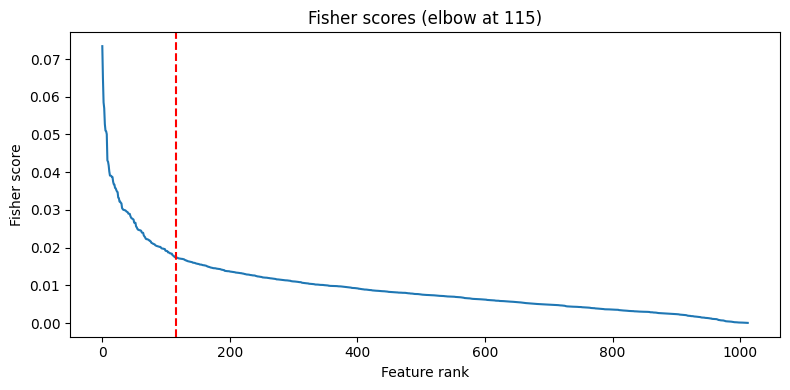

After Fisher elbow: D = 115
After correlation groups pick for best MI: D = 64


In [ ]:
class FeatureSelection:
    """
    combine selected features into one (N,D) every individual feature dimension can be dropped.
    Have a 'fit_select' function for training data and a 'select' for validation and test data.
    """
    def __init__(self, X_features: np.ndarray, Y_data: np.ndarray, feature_slices: dict, scaler: StandardScaler, verbose: bool = False):
        self.X = X_features
        self.Y = Y_data
        self.feature_slices = feature_slices
        
        self.scaler = None
        self.kept_cols = np.arange(self.X.shape[1])  # track surviving columns
        self.vt = None

        self.verbose = verbose

    def _scale_features(self) -> None:
        """ 
        Center each feature to 0 and scale to unit variance.
        Do this step to prevent features computed at different scales t
        Scale based on training data
        """
        self.X = self.scaler.fit_transform(self.X)
                
    def _drop_low_variance(self, threshold:float = 1e-3) -> None:
        """ drop features that barely vary over samples
        This automatically drops duplicates and constant(0-info) features; they also get flagged by low variance. """
        vt= VarianceThreshold(threshold=threshold)
        self.X = vt.fit_transform(self.X)
        self.kept_cols = vt.get_support(indices=True)
    
    def _drop_low_fisher_score(self, keep_minimum_d: int = 20) -> None:
        """Drop features with Fisher score below the knee; 
        keep a minimum amount of dimensions incase the knee is very aggresive"""
        X = self.X.astype(np.float64, copy=False)
        y = np.asarray(self.Y)

        # fisher per column (multiclass)
        mu = np.nanmean(X, axis=0)
        Sb = np.zeros(X.shape[1], dtype=np.float64)
        Sw = np.zeros(X.shape[1], dtype=np.float64)
        classes = np.unique(y)
        for c in classes:
            m = (y == c)
            if not np.any(m):
                continue
            Xc = X[m]
            nc = Xc.shape[0]
            mu_c = np.nanmean(Xc, axis=0)
            var_c = np.nanvar(Xc, axis=0)
            Sb += nc * (mu_c - mu) ** 2
            Sw += nc * var_c
        fisher = Sb / (Sw + 1e-12)
        fisher = np.nan_to_num(fisher, nan=0.0, posinf=0.0, neginf=0.0)

        D = fisher.shape[0]
        if D == 0:
            return

        # sort descending, find elbow on the curve
        order = np.argsort(-fisher) # high -> low
        y_sorted = fisher[order]
        x = np.arange(D, dtype=float)
        if D == 1:
            k_elbow = 1
        else:
            x0, y0 = 0.0, y_sorted[0]
            x1, y1 = float(D - 1), y_sorted[-1]
            denom = np.hypot(x1 - x0, y1 - y0) + 1e-12
            dist = np.abs((y1 - y0) * x - (x1 - x0) * y_sorted + x1 * y0 - y1 * x0) / denom
            k_elbow = int(np.argmax(dist)) + 1  # keep up to and including elbow point

        # keep at least min_keep; at most D
        k = int(np.clip(k_elbow, keep_minimum_d, D))
        if keep_minimum_d > k_elbow and self.verbose:
            print(f"keep minimum: {keep_minimum_d}, the elbow is at {k_elbow}")

        keep_mask_sorted = np.zeros(D, dtype=bool)
        keep_mask_sorted[:k] = True
        keep_mask = np.zeros(D, dtype=bool)
        keep_mask[order] = keep_mask_sorted

        # plot the fisher score with the elbow line to check if it seems natural
        if self.verbose:
            scores = np.sort(fisher)[::-1]
            plt.figure(figsize=(8,4))
            plt.plot(scores)
            plt.axvline(k_elbow, color='r', linestyle='--')
            plt.title(f"Fisher scores (elbow at {k_elbow})")
            plt.xlabel("Feature rank")
            plt.ylabel("Fisher score")
            plt.tight_layout()
            plt.show()

        # apply mask
        self.X = self.X[:, keep_mask]
        self.kept_cols = self.kept_cols[keep_mask]
    
    def _corr_groups(self, threshold: float = 0.90) -> list[np.ndarray]:
        """ make groups of columns where |corr| >= threshold (connected components) """
        if self.X.shape[1] == 0:
            return []
        C = np.corrcoef(self.X, rowvar=False)
        C = np.nan_to_num(np.abs(C), nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(C, 0.0) # Ignore the perfect correlation on the diagonal
        adj = (C >= threshold).astype(np.uint8)
        g = csr_matrix(adj)
        n_comp, labels = connected_components(csgraph=g, directed=False, return_labels=True)
        return [np.where(labels == i)[0] for i in range(n_comp)]

    def _reduce_corr_by_mi(self, corr_threshold: float = 0.90) -> None:
        """ within each corr-group, keep only the column with highest MI (single in the group always kept) """
        if self.X.shape[1] == 0:
            return
        groups = self._corr_groups(threshold=corr_threshold)
        # MI on current set
        Xsafe = np.nan_to_num(self.X, copy=False)  # handle inf/nan
        mi = mutual_info_classif(Xsafe, self.Y, discrete_features=False, random_state=1712411)

        keep = np.zeros(self.X.shape[1], dtype=bool)
        for g in groups:
            if g.size == 1:
                keep[g[0]] = True
            else:
                best = g[np.argmax(mi[g])]
                keep[best] = True

        self.X = self.X[:, keep]
        self.kept_cols = self.kept_cols[keep]

    def fit_select_features(self,
                        var_threshold: float = 1e-3,
                        fisher_min_keep: int = 20,
                        corr_threshold: float = 0.90):
        """ progressively drop feature dimensions according to scores """
        self._scale_features()
        if self.verbose:
            print(f"Start: D = {self.X.shape[1]}")
        self._drop_low_variance(threshold=var_threshold)
        if self.verbose:
            print(f"After low variance: D = {self.X.shape[1]}")
        self._drop_low_fisher_score(keep_minimum_d=fisher_min_keep)
        if self.verbose:
            print(f"After Fisher elbow: D = {self.X.shape[1]}")
        self._reduce_corr_by_mi(corr_threshold=corr_threshold)
        if self.verbose:
            print(f"After correlation groups pick for best MI: D = {self.X.shape[1]}")
        return self.X

    def select_features(self):
        """ progressively drop feature dimensions according to scores """
        self._scale_features()
        if self.verbose:
            print(f"Start: D = {self.X.shape[1]}")
        self._drop_low_variance(threshold=var_threshold)
        if self.verbose:
            print(f"After low variance: D = {self.X.shape[1]}")
        self._drop_low_fisher_score(keep_minimum_d=fisher_min_keep)
        if self.verbose:
            print(f"After Fisher elbow: D = {self.X.shape[1]}")
        self._reduce_corr_by_mi(corr_threshold=corr_threshold)
        if self.verbose:
            print(f"After correlation groups pick for best MI: D = {self.X.shape[1]}")
        return self.X

features_selector = FeatureSelection(feature_slices, verbose=True)

X_train_selected = features_selector.fit_select_features(X_train_features, train_data.Y_data_augmented,)

for 'features_1' without fisher step, correlation + MI gives 432 features

For building a latent representation from the important feature dimensions, use:
- PCA
- ICA
- Autoencoder
- UMAP (Uniform Manifold Approximation and Projection)
    - assumes low D data lies embedded in high-D space; similar to t-SNE but faster 
    - build a fuzzy topological graph of data in high-D
    - optimize a low-D embedding that best preserves this graphs structure

In [ ]:
class BuildLatentRepresentation:
    """
    Use PCA and ICA to turn features into an information dense representation
    """
    def __init__(self):
        pass


### Machine learning models
The Models used are:
Models used:
- SVM (support vector machine)
    - features used: ...
- MLP
- Random forest
- Fuzzy system 
    - suited for relativly low dimensions; so either use low dimensional features or implement dimensionality reduction
Evaluation is done based on:
...

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
# X_val_scaled = scaler.transform(X_val_hog)

In [ ]:

# model_svm = SVC(kernel='rbf', class_weight='balanced')
# model_svm.fit(X_train_scaled, y_train)

: 

: 